# Fuel Consumption Estimation of Vehicles

In this project, we will code a program that can predict the fuel consumption of a vehicle using the Auto MPG Data Set from the UC Irvine Machine Learning Repository. You can get the original dataset and more information about it from the below link. We will follow the path below during the project.

**Link for the Dataset**: https://archive.ics.uci.edu/ml/datasets/Auto+MPG

## Context

* Importing the Required Libraries and Dataset
* Missing Values
* Explanatory Data Analysis (EDA)
* Outliers
* Feature Engineering
* Splitting and Standardization
* Linear Regression
* Regularization
    * Ridge Regression
    * Lasso Regression
    * ElasticNet
* XGBoost
* Averaging the Models
* Results

Now, let's start with the first part, which is importing the libraries and dataset.

## Importing the Required Libraries and Dataset

In [1]:
# import the required libraries and dataset

# to import the data
import pandas as pd

# to visualize
import seaborn as sns
import matplotlib.pyplot as plt

# to do math
import numpy as np
from scipy import stats
from scipy.stats import norm, skew

# to standardize the data
from sklearn.preprocessing import RobustScaler, StandardScaler

# to create the models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import xgboost as xgb

# to split the data
from sklearn.model_selection import train_test_split, GridSearchCV

# to calculate the error
from sklearn.metrics import mean_squared_error, accuracy_score

# to average the models
from sklearn.base import clone

# to get rid of the warnings
import warnings
warnings.filterwarnings("ignore")

As you see, we imported the libraries we will use, and now we are ready to import the data. First, we need to define the column names. We have already known the column names from the dataset description, so we will use them, and we will ignore the car name column because it is not necessary for our project.

In [2]:
# import the data

columnNames = ["MPG", "Cylinders", "Displacement", 
               "Horsepower", "Weight", "Acceleration", 
               "Model Year", "Origin"]

data = pd.read_csv("auto-mpg.data", 
                   names = columnNames, 
                   na_values = "?", 
                   comment = "\t", 
                   sep = " ", 
                   skipinitialspace = "True")

data = data.rename(columns = {"MPG": "Target"})

print("Data Shape:", data.shape)
data.head()

Data Shape: (398, 8)


,Target,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


Now, let's look at the data in more detail.

In [3]:
# some fundamental information about the data

data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Target        398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


,Target,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


When looking at the first table above, we can conclude that we have eight missing values in the horsepower column in total, so we need to deal with them. Also, when looking at the mean and 50% rows in the second table, there is positive skewness in some columns. Now, let's continue with the next part.

## Missing Values

Since the mean and median values are close to each other in the horsepower column, It will be reasonable to fill them with their mean value.

In [4]:
# fill the missing values

data["Horsepower"] = data["Horsepower"].fillna(data["Horsepower"].mean())

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Target        398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    398 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


As you see, we filled all missing values, so we can continue with the EDA.

## Explanatory Data Analysis (EDA)

In this part, we will try to understand the relationships among the features. Firstly, we can start to create a correlation matrix.

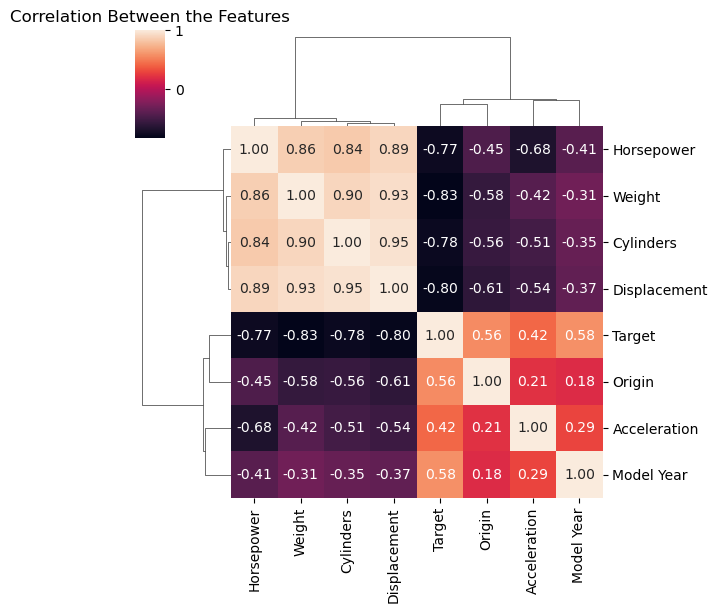

In [5]:
# create the correlation matrix

corrMatrix = data.corr()

sns.clustermap(corrMatrix, annot = True, fmt = ".2f", figsize = (6, 6))
plt.title("Correlation Between the Features")
plt.show()

When looking at the graph, the horsepower, weight, cylinders and displacement features have quite strong relationship with the target feature. Now, for the sake of simplicity, let's simplify the matrix.

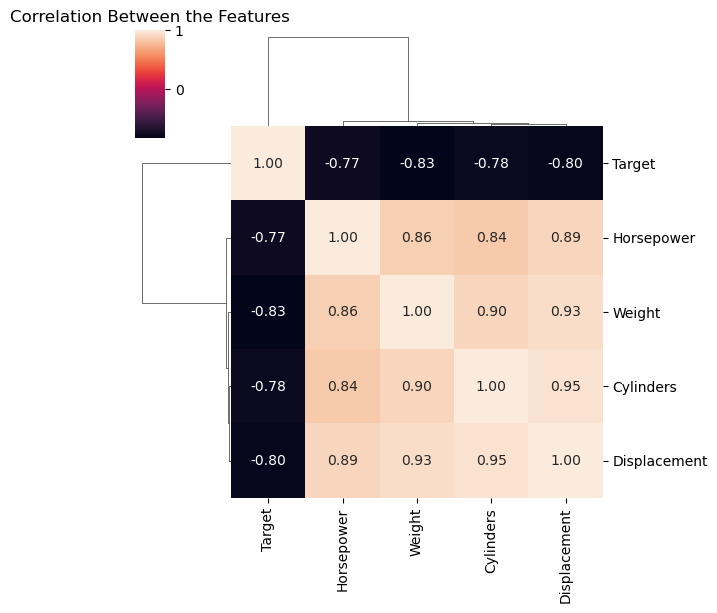

In [6]:
# simplify the correlation matrix

threshold = 0.75
filt = np.abs(corrMatrix["Target"]) > threshold

corrFeatures = corrMatrix.columns[filt].tolist()

sns.clustermap(data[corrFeatures].corr(), annot = True, fmt = ".2f", figsize = (6, 6))
plt.title("Correlation Between the Features")
plt.show()

Although some features and the target feature have a strong relationship, features also have quite strong relationships among themselves. This is not good news, because it means that more than one feature contains the same information. This circumstance is called muticolinearity, and we need to get rid of it. Now, let's examine the relationships between features in detail.

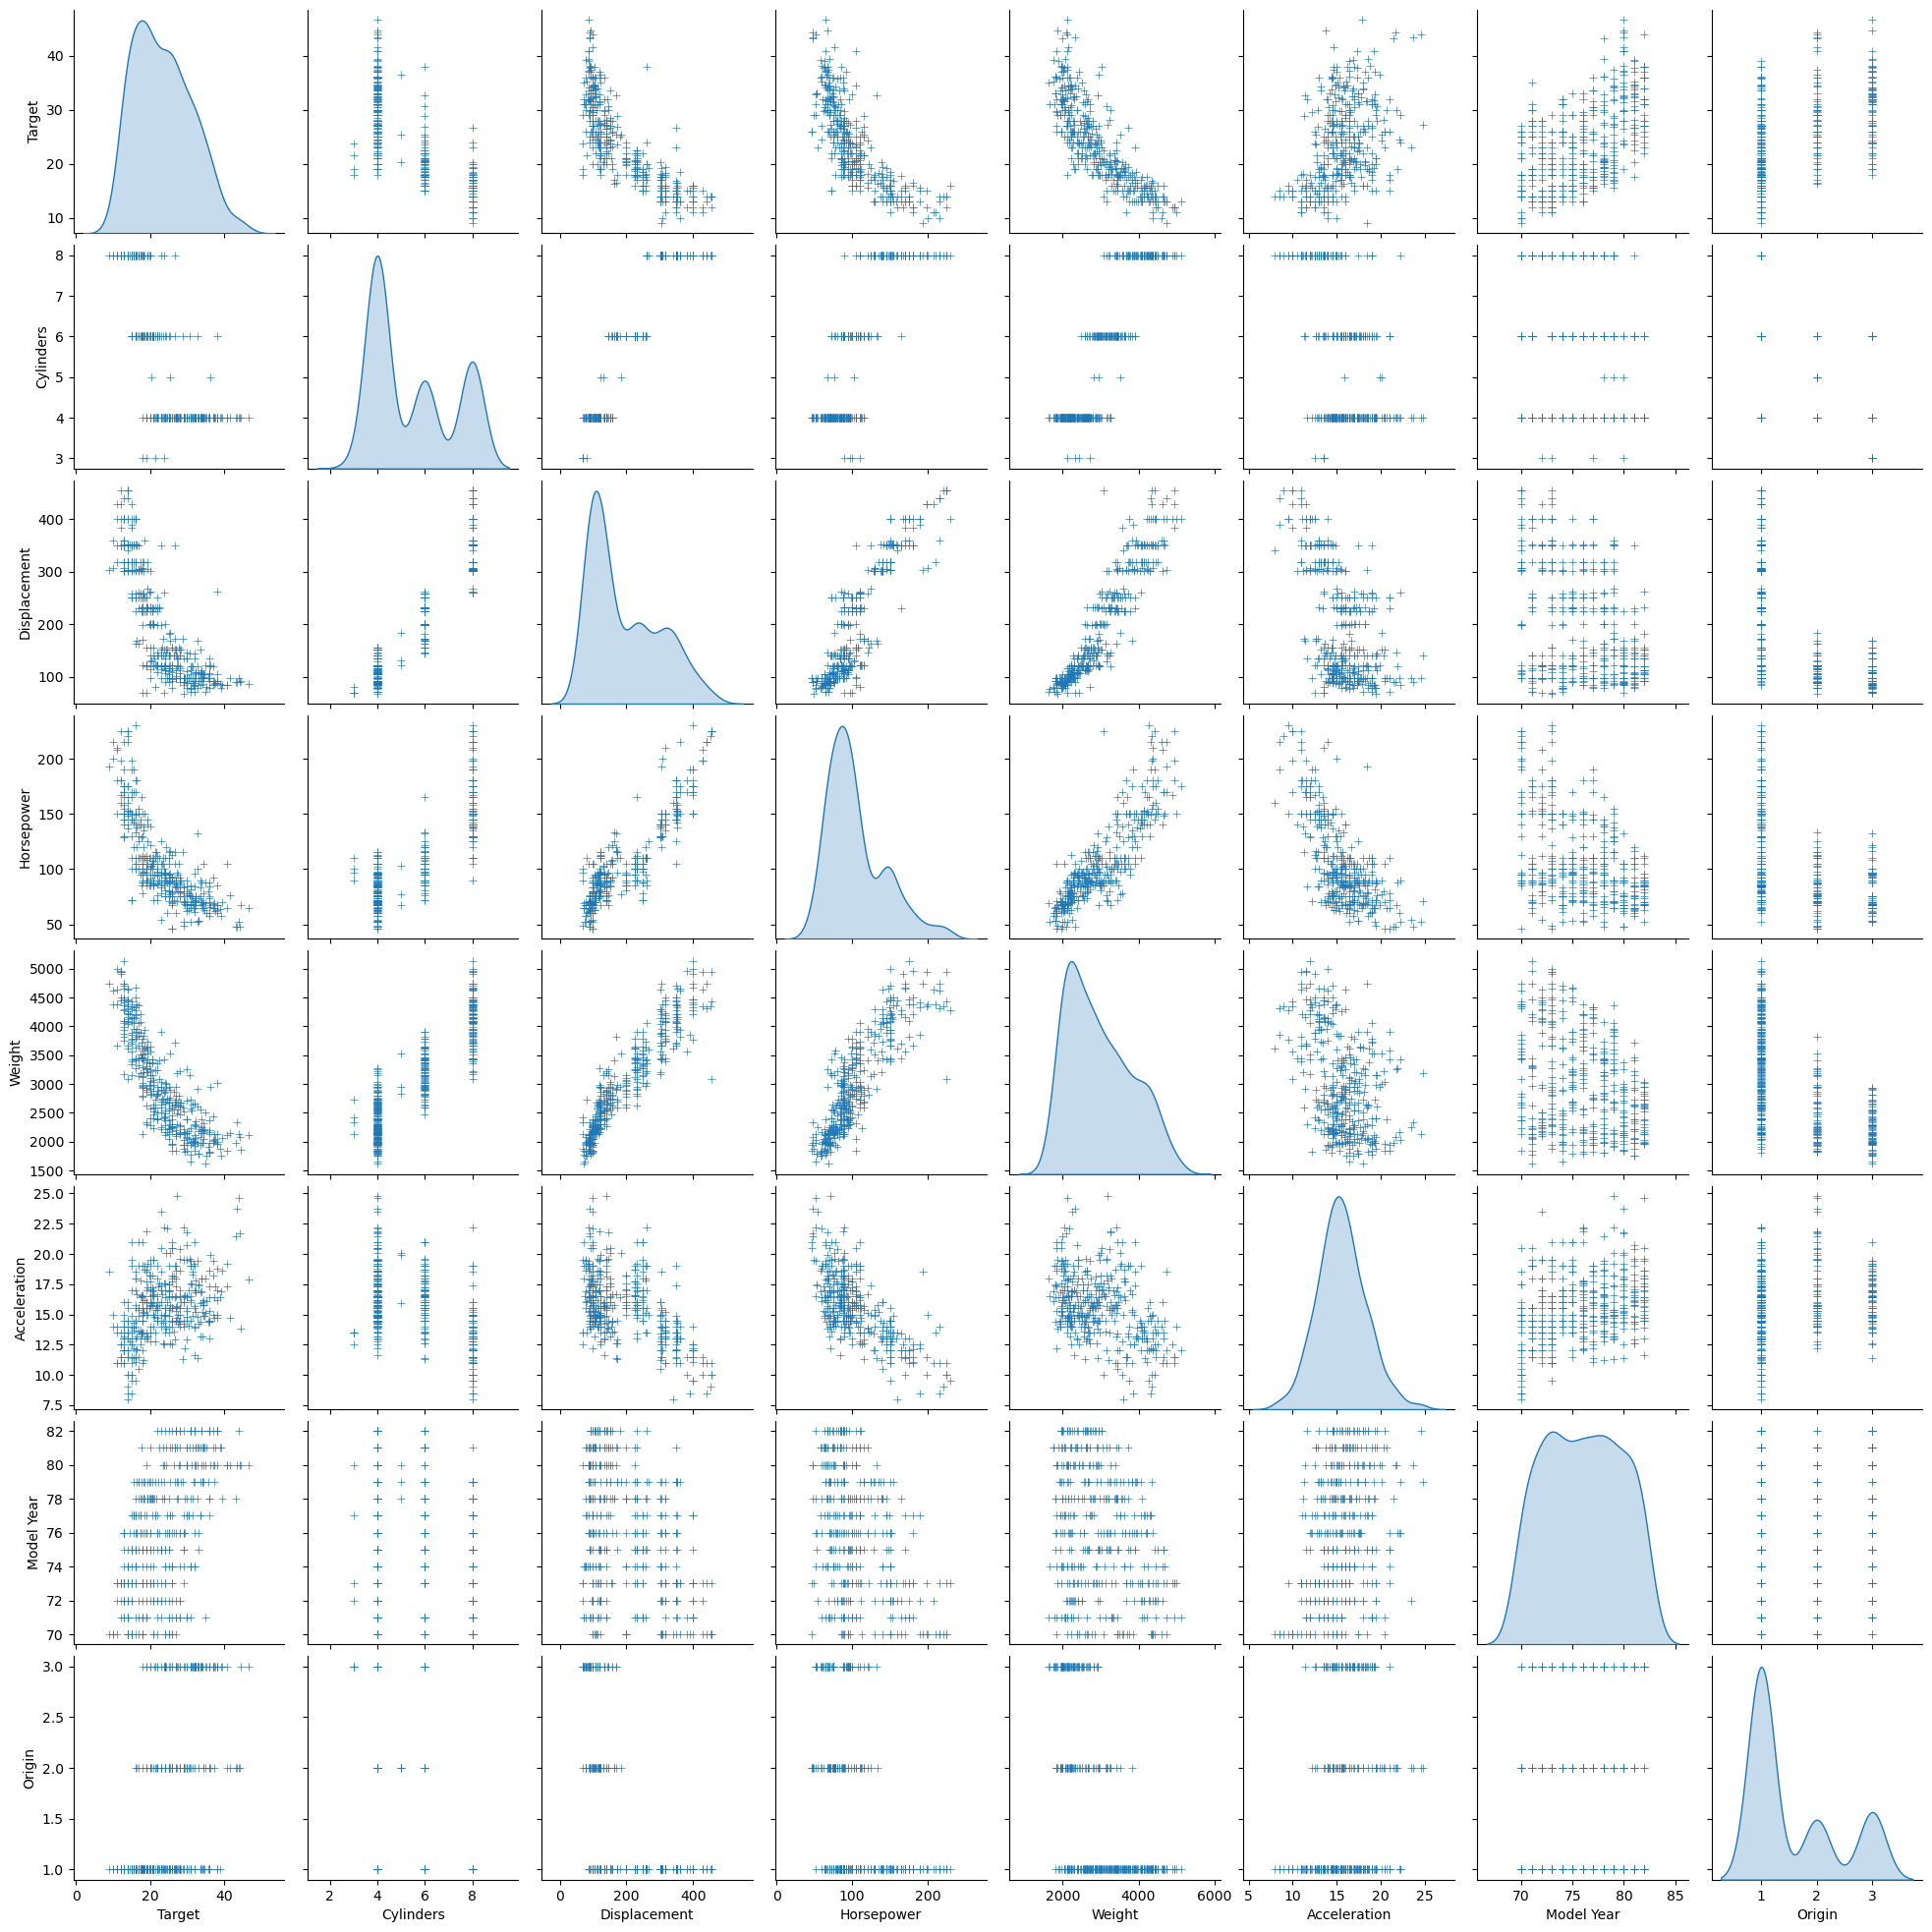

In [7]:
# create a pair plot

sns.pairplot(data, diag_kind = "kde", markers = "+")
plt.show()

As shown in the above graphs, we can consider the cylinder and origin features as categorical features. Therefore, we can imply the one-hot encoding method to them. We will do that in the feature engineering part. Before continuing, let's take a closer look at the cylinders and origin features to make sure.

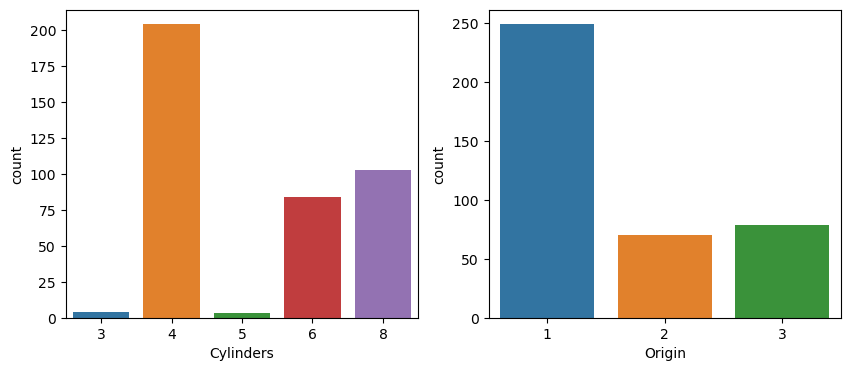

In [8]:
# visualize the cylinder and origin features

fig, ax = plt.subplots(1, 2, figsize = (10, 4))

sns.countplot(x = data["Cylinders"], ax = ax[0])
sns.countplot(x = data["Origin"], ax = ax[1])

plt.show()

Now, we will create box plots to detect the outliers. Then we will get rid of them in the next part.

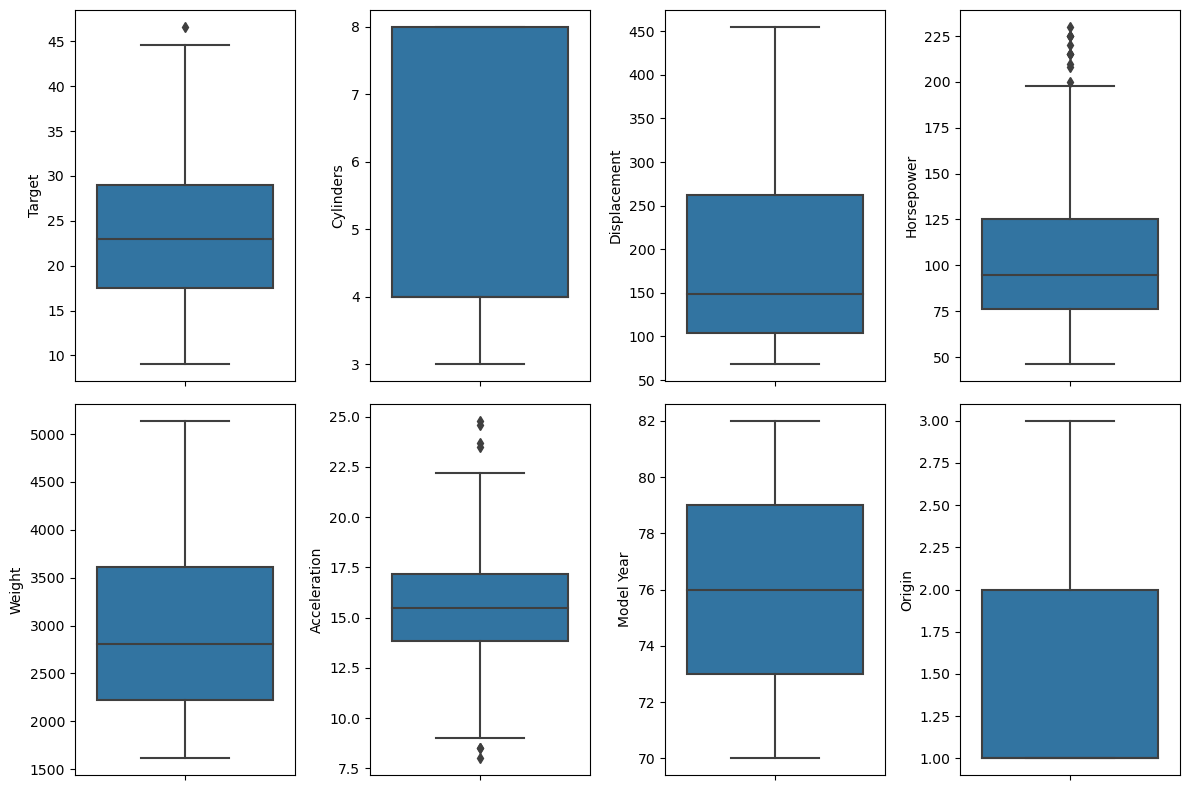

In [9]:
# detect the outliers via box plots

fig, ax = plt.subplots(2, 4, figsize = (12, 8))

k = 0
for i in range(2):
    for j in range(4):
        sns.boxplot(y = data.columns[k], data = data, orient = 'v', ax = ax[i, j])
        k += 1
        
plt.tight_layout()
plt.show()

There are outliers in the horsepower and acceleration features. We need to throw away them. Let's continue with the next part.

## Outliers

As we mentioned above, we have outliers in the horsepower and acceleration columns. Now, let's deal with them.

In [10]:
# set the threshold

threshold = 1.5

In [11]:
# outlier detection for the horsepower column

horsepowerDesc = data["Horsepower"].describe()

horsepowerQ3 = horsepowerDesc[6]
horsepowerQ1 = horsepowerDesc[4]
horsepowerIQR = horsepowerQ3 - horsepowerQ1

horsepowerTop = horsepowerQ3 + threshold * horsepowerIQR
horsepowerBottom = horsepowerQ1 - threshold * horsepowerIQR

filtForTop =  horsepowerTop > data["Horsepower"]
filtForBottom = horsepowerBottom < data["Horsepower"]
filtHorsepower = filtForBottom & filtForTop

data = data[filtHorsepower]

In [12]:
# outlier detection for the acceleration column

accelerationDesc = data["Acceleration"].describe()

accelerationQ3 = accelerationDesc[6]
accelerationQ1 = accelerationDesc[4]
accelerationIQR = accelerationQ3 - accelerationQ1

accelerationTop = accelerationQ3 + threshold * accelerationIQR
accelerationBottom = accelerationQ1 - threshold * accelerationIQR

filtForTop =  accelerationTop > data["Acceleration"]
filtForBottom = accelerationBottom < data["Acceleration"]
filtAcceleration = filtForBottom & filtForTop

data = data[filtAcceleration]

Now, we removed the outliers from the data, so we can continue with the next part.

## Feature Engineering

In this part, we are going to deal with the skewness of data and imply the one-hot encoding method. As you see in the pair plot above, some features do not behave like a normal distribution. This will affect the accuracy score negatively, so first of all, we need to decrease the skewness by applying the log-transformation. Let's start with the target column.

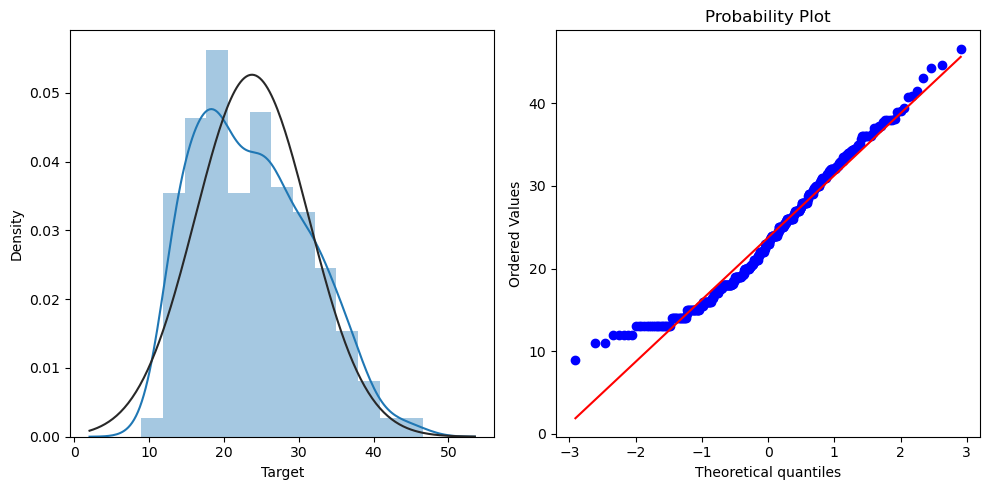

mu: 23.762, sigma: 7.581


In [13]:
# skewness in the target column

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

sns.distplot(data["Target"], fit = norm, ax = ax[0])
stats.probplot(data["Target"], plot = plt)

plt.tight_layout()
plt.show()

mu, sigma = norm.fit(data["Target"])
print("mu: {:.3f}, sigma: {:.3f}".format(mu, sigma))

As you see, the target values do not fit the normal distribution completely. Now, let's apply the log-transformation

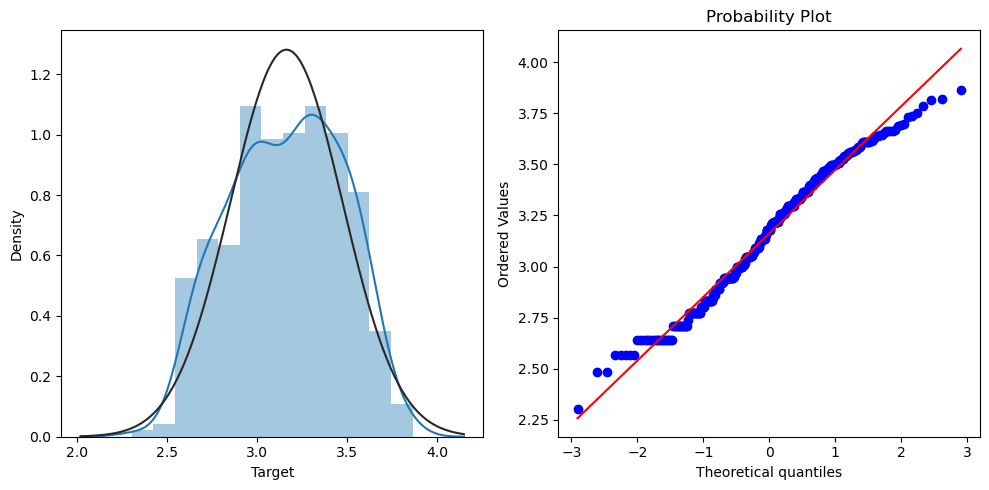

mu: 3.162, sigma: 0.311


In [14]:
# apply log-transformation

data["Target"] = np.log1p(data["Target"])

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

sns.distplot(data["Target"], fit = norm, ax = ax[0])
stats.probplot(data["Target"], plot = plt)

plt.tight_layout()
plt.show()

mu, sigma = norm.fit(data["Target"])
print("mu: {:.3f}, sigma: {:.3f}".format(mu, sigma))

After the transformation process, the data is now more suitable for the normal distribution as you see. Now, let's look at other features.

In [15]:
# skewness in other features

skewedFeatures = data.apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness = pd.DataFrame(skewedFeatures, columns = ["Skew"])

skewness

,Skew
Origin,0.882740
Horsepower,0.855351
Displacement,0.702323
Cylinders,0.598230
Weight,0.566934
Acceleration,0.256853
Model Year,-0.010564
Target,-0.113193


Although the horsepower and origin values are a little bit skewed, it is not a big deal. However, if you face a skewness problem in your next projects, you can use the Box Cox Transformation to deal with it. For more information about Box Cox Transformation, you can click the following link: https://www.geeksforgeeks.org/box-cox-transformation-using-python/

**Note**: If the values in the skew column are bigger than 1 or less than -1, the skewness exists.

Now, we can continue with the one-hot encoding.

In [16]:
# apply one-hot encoding to the cylinder and origin columns

data["Cylinders"] = data["Cylinders"].astype(str)
data["Origin"] = data["Origin"].astype(str)

data = pd.get_dummies(data)

data.head()

,Target,Displacement,Horsepower,Weight,Acceleration,Model Year,Cylinders_3,Cylinders_4,Cylinders_5,Cylinders_6,Cylinders_8,Origin_1,Origin_2,Origin_3
0,2.944439,307.0,130.0,3504.0,12.0,70,0,0,0,0,1,1,0,0
1,2.772589,350.0,165.0,3693.0,11.5,70,0,0,0,0,1,1,0,0
2,2.944439,318.0,150.0,3436.0,11.0,70,0,0,0,0,1,1,0,0
3,2.833213,304.0,150.0,3433.0,12.0,70,0,0,0,0,1,1,0,0
4,2.890372,302.0,140.0,3449.0,10.5,70,0,0,0,0,1,1,0,0


Now that the feature engineering part is done, let's continue with the next part, which is splitting and standardization.

## Splitting and Standardization

Now, we will first split the data. Then, we will standardize it to use in the models that we will create.

In [17]:
# split as train and test

x = data.drop(["Target"], axis = 1)
y = data["Target"]

testSize = 0.2

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = testSize, random_state = 42)

In [18]:
# standardization

scaler = StandardScaler()
xTrain = scaler.fit_transform(xTrain)
xTest = scaler.transform(xTest)

Up to now, we dealt with the data preprocessing. Now, we are ready to create our models and train them. Let's start with the first model Linear Regression.

## Linear Regression

Before applying the Linear Regression method, let's create a dictionary to hold the mse values.

In [19]:
# create a dictionary to hold the mse values

mseValues = dict()

In [20]:
# linear regression

lr = LinearRegression()
lr.fit(xTrain, yTrain)

print("Linear Regression Coefficients: {}".format(lr.coef_))

yPredictedDummy = lr.predict(xTest)
mse = mean_squared_error(yTest, yPredictedDummy)

print("Linear Regression MSE:", mse)

mseValues["Linear Regression"] = mse

Linear Regression Coefficients: [ 0.03412938 -0.07139037 -0.1719396  -0.01260748  0.1014336  -0.02011411
  0.02469682  0.00764684 -0.02017794 -0.00717274 -0.01630873  0.00831868
  0.01177111]
Linear Regression MSE: 0.009593900918505772


We got the mse value from the first model. Now, we will use the second model, which is Ridge Regression. It is a regularization technique to prevent a possible overfitting problem. Let's continue with it.

## Regularization

In this part, we will use three different regularization techniques to get lower mse values.

### Ridge Regression

We will now apply the Ridge Regression method. Since the Ridge Regression contains some hyperparameters, and we want to find the best model, we will use the Grid Search Cross Validation method.

Ridge Regression Coefficients: [ 0.03115671 -0.07189863 -0.16948321 -0.01301136  0.10117509 -0.02027292
  0.0243732   0.00753741 -0.02019468 -0.00671392 -0.01616772  0.00815208
  0.01175914]
Ridge Regression MSE: 0.009579590336660435


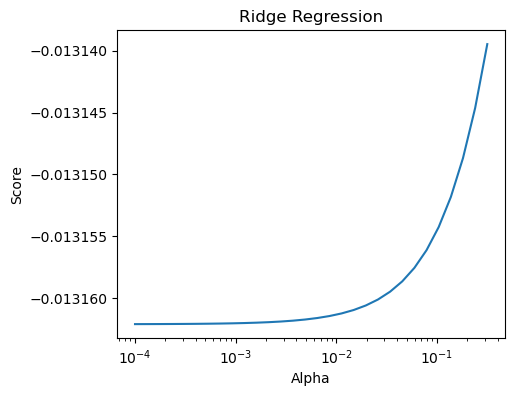

In [21]:
# ridge regression (L2)

ridge = Ridge(random_state = 42, max_iter = 10000)

alphas = np.logspace(-4, -0.5, 30)

tunedParams = [{"alpha": alphas}]
nFolds = 5

clf = GridSearchCV(ridge, tunedParams, cv = nFolds, scoring = "neg_mean_squared_error", refit = True)
clf.fit(xTrain, yTrain)

ridge = clf.best_estimator_

scores = clf.cv_results_["mean_test_score"]
scoresStd = clf.cv_results_["std_test_score"]

print("Ridge Regression Coefficients: {}".format(clf.best_estimator_.coef_))

yPredictedDummy = clf.predict(xTest)
mse = mean_squared_error(yTest, yPredictedDummy)

print("Ridge Regression MSE:", mse)

plt.figure(figsize = (5, 4))

plt.semilogx(alphas, scores)
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.title("Ridge Regression")

plt.show()

mseValues["Ridge Regression"] = mse

As you see, when applying the ridge regression, the mse value has dropped slightly. Now, let's create the next model Lasso Regression.

### Lasso Regression

Lasso Regression Coefficients: [-0.         -0.05380102 -0.16583688 -0.0046199   0.09973546 -0.01904356
  0.01655016  0.00350548 -0.01816066 -0.         -0.02275946  0.
  0.00081126]
Lasso Regression MSE: 0.00945655760417978


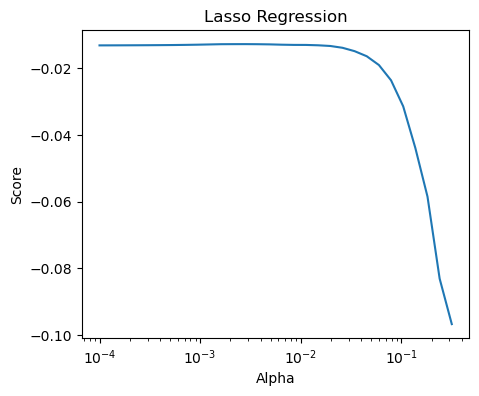

In [22]:
# lasso regression (L1)

lasso = Lasso(random_state = 42, max_iter = 10000)

alphas = np.logspace(-4, -0.5, 30)

tunedParams = [{"alpha": alphas}]
nFolds = 5

clf = GridSearchCV(lasso, tunedParams, cv = nFolds, scoring = "neg_mean_squared_error", refit = True)
clf.fit(xTrain, yTrain)

lasso = clf.best_estimator_

scores = clf.cv_results_["mean_test_score"]
scoresStd = clf.cv_results_["std_test_score"]

print("Lasso Regression Coefficients: {}".format(clf.best_estimator_.coef_))

yPredictedDummy = clf.predict(xTest)
mse = mean_squared_error(yTest, yPredictedDummy)

print("Lasso Regression MSE:", mse)

plt.figure(figsize = (5, 4))

plt.semilogx(alphas, scores)
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.title("Lasso Regression")

plt.show()

mseValues["Lasso Regression"] = mse

The mse value has slightly dropped again thanks to the lasso regression. Let's continue with the next model, which is ElasticNet

### ElasticNet

We can say for the ElasticNet that it is the mixture of the Ridge and Lasso Regression models.

In [23]:
# elasticNet

eNet = ElasticNet(random_state = 42, max_iter = 10000)

alphas = np.logspace(-4, -0.5, 30)

tunedParams = [{"alpha": alphas, "l1_ratio": np.arange(0.0, 1.0, 0.05)}]
nFolds = 5

clf = GridSearchCV(eNet, tunedParams, cv = nFolds, scoring = "neg_mean_squared_error", refit = True)
clf.fit(xTrain, yTrain)

eNet = clf.best_estimator_

scores = clf.cv_results_["mean_test_score"]
scoresStd = clf.cv_results_["std_test_score"]

print("ElasticNet Coefficients: {}".format(clf.best_estimator_.coef_))

yPredictedDummy = clf.predict(xTest)
mse = mean_squared_error(yTest, yPredictedDummy)

print("ElasticNet MSE:", mse)

mseValues["ElasticNet"] = mse

ElasticNet Coefficients: [-0.         -0.05479586 -0.16523986 -0.00518481  0.09973338 -0.01923399
  0.01649696  0.00363541 -0.01833243 -0.         -0.02274718  0.
  0.00097686]
ElasticNet MSE: 0.009452319705534732


We completed the reqularization techniques. As you see, we got the minimum mse value in the last model, which is the ElasticNet. Now, we will continue with the XGBoost part.

## XGBoost

XGBoost is the newest model of the models that we used. Generally, it is used for quite complicated datasets, so it is not completely suitable for our dataset. However, since it is a really powerful model, it will decrease the mse value.

In [24]:
# xgboost

xgbModel = xgb.XGBRegressor()

tunedParams = {"nthread": [4],
               "objective": ["reg:squarederror"],
               "learning_rate": [0.03, 0.05, 0.07],
               "max_depth": [5, 6, 7],
               "min_child_weight": [4],
               "subsample": [0.7],
               "colsample_bytree": [0.7],
               "n_estimators": [500, 1000]}
nFolds = 5

clf = GridSearchCV(xgbModel, 
                   tunedParams, 
                   cv = nFolds, 
                   scoring = "neg_mean_squared_error", 
                   refit = True, 
                   n_jobs = 5)
clf.fit(xTrain, yTrain)

xgbModel = clf.best_estimator_

yPredictedDummy = clf.predict(xTest)
mse = mean_squared_error(yTest, yPredictedDummy)

print("XGBoost MSE:", mse)

mseValues["XGBoost"] = mse

XGBoost MSE: 0.007927186700676334


Thanks to the XGBoost model, we got a lesser mse value. Now, we can continue with the next part.

## Averaging the Models

In this part, we will concatenate the two best models to increase our score. When looking at the mse values, the two best models are ElasticNet and XGBoost. Let's concatenate them.

In [25]:
# create the AveragingModels class

class AveragingModels():
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)
            
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        
        return np.mean(predictions, axis = 1)
    
averagedModels = AveragingModels(models = (xgbModel, eNet))
averagedModels.fit(xTrain, yTrain)

yPredictedDummy = averagedModels.predict(xTest)
mse = mean_squared_error(yTest, yPredictedDummy)

print("Averaged Models MSE:", mse)

mseValues["Averaged Models"] = mse

Averaged Models MSE: 0.007088510439036205


As you can see, the mse value has been the lowest one we have ever seen, so this is our final mse value.

## Results

Let's visualize the mse values that we found.

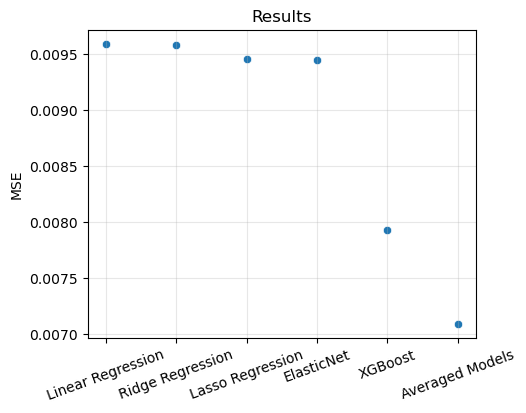

In [26]:
# results

plt.figure(figsize = (5, 4))

sns.scatterplot(x = mseValues.keys(), y = mseValues.values())
plt.title("Results")
plt.ylabel("MSE")
plt.xticks(rotation = 20)
plt.grid(alpha = 0.3)

plt.show()

In this notebook, we tried to predict the MPG (miles per gallon) values of vehicles using the Auto MPG Data Set. During the notebook, we used a lot of models to improve our predictions, and finally we got a mse value.

## Sources

* Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.